Starting ECG import..


100%|██████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 1418.96it/s]


Finished!
Starting ECG import..


100%|███████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 793.57it/s]


Finished!


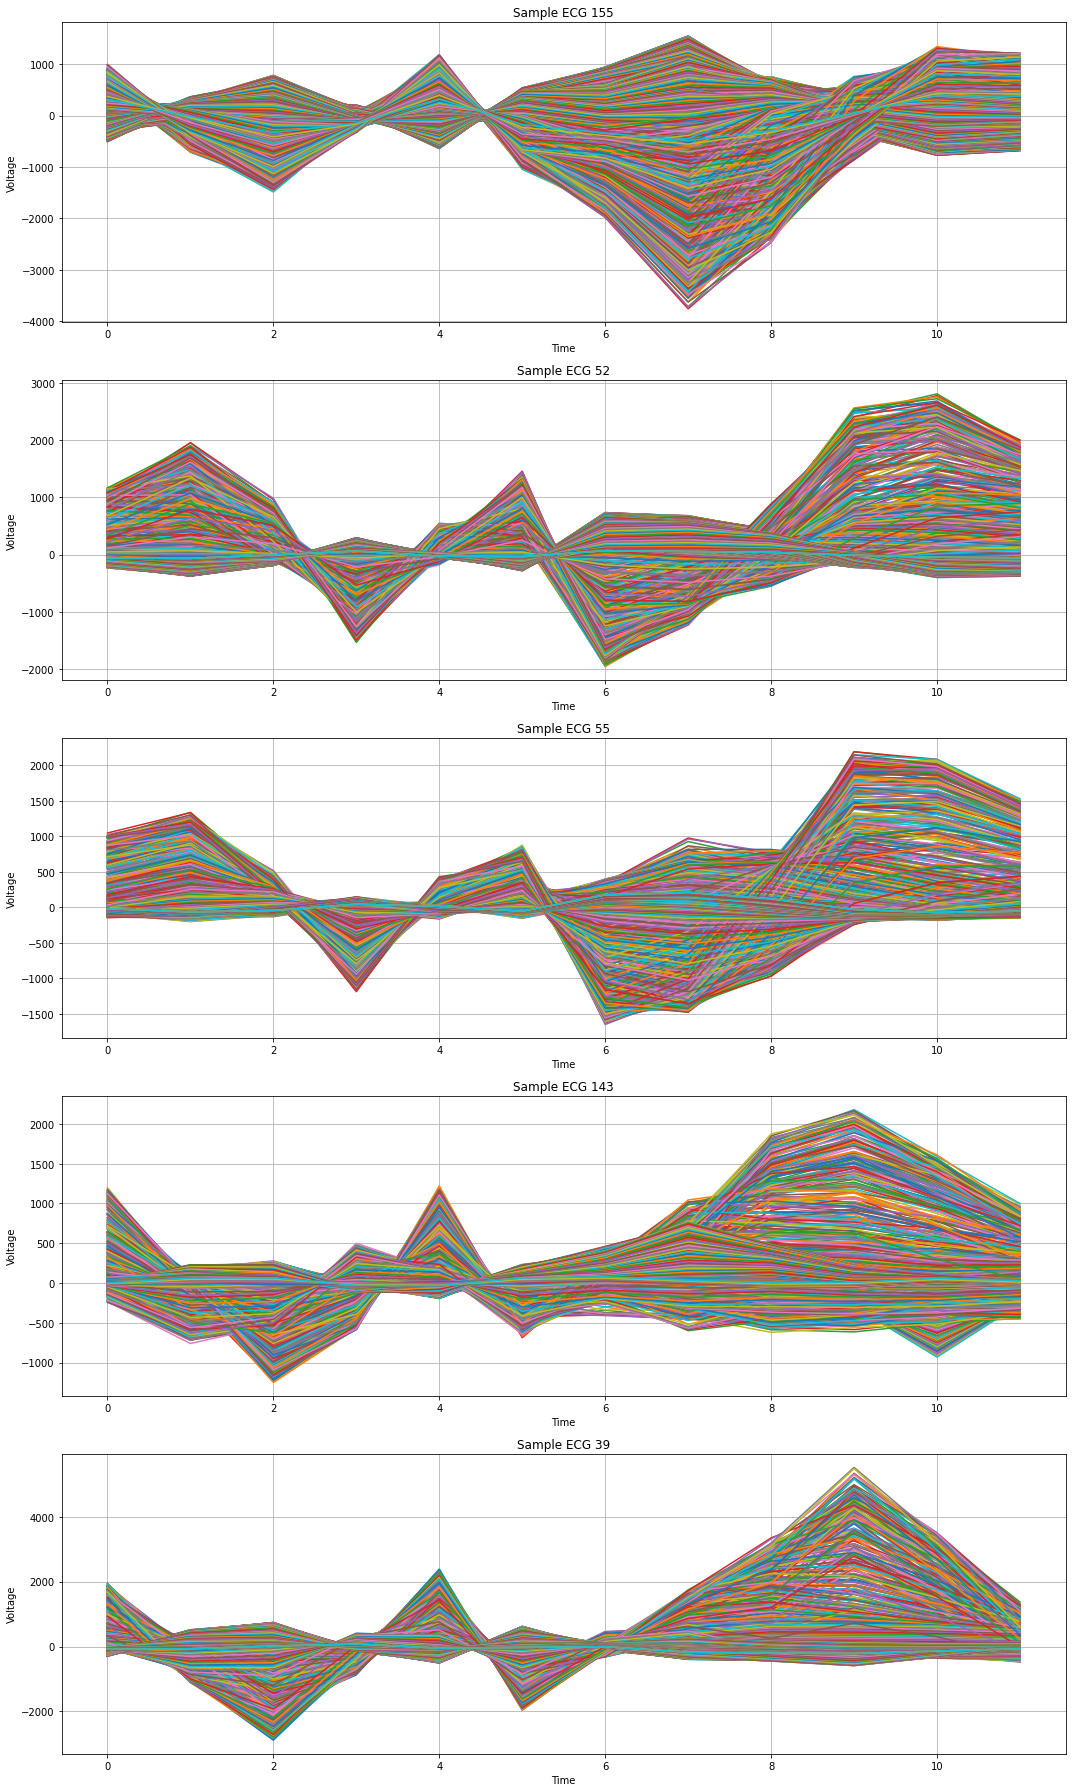

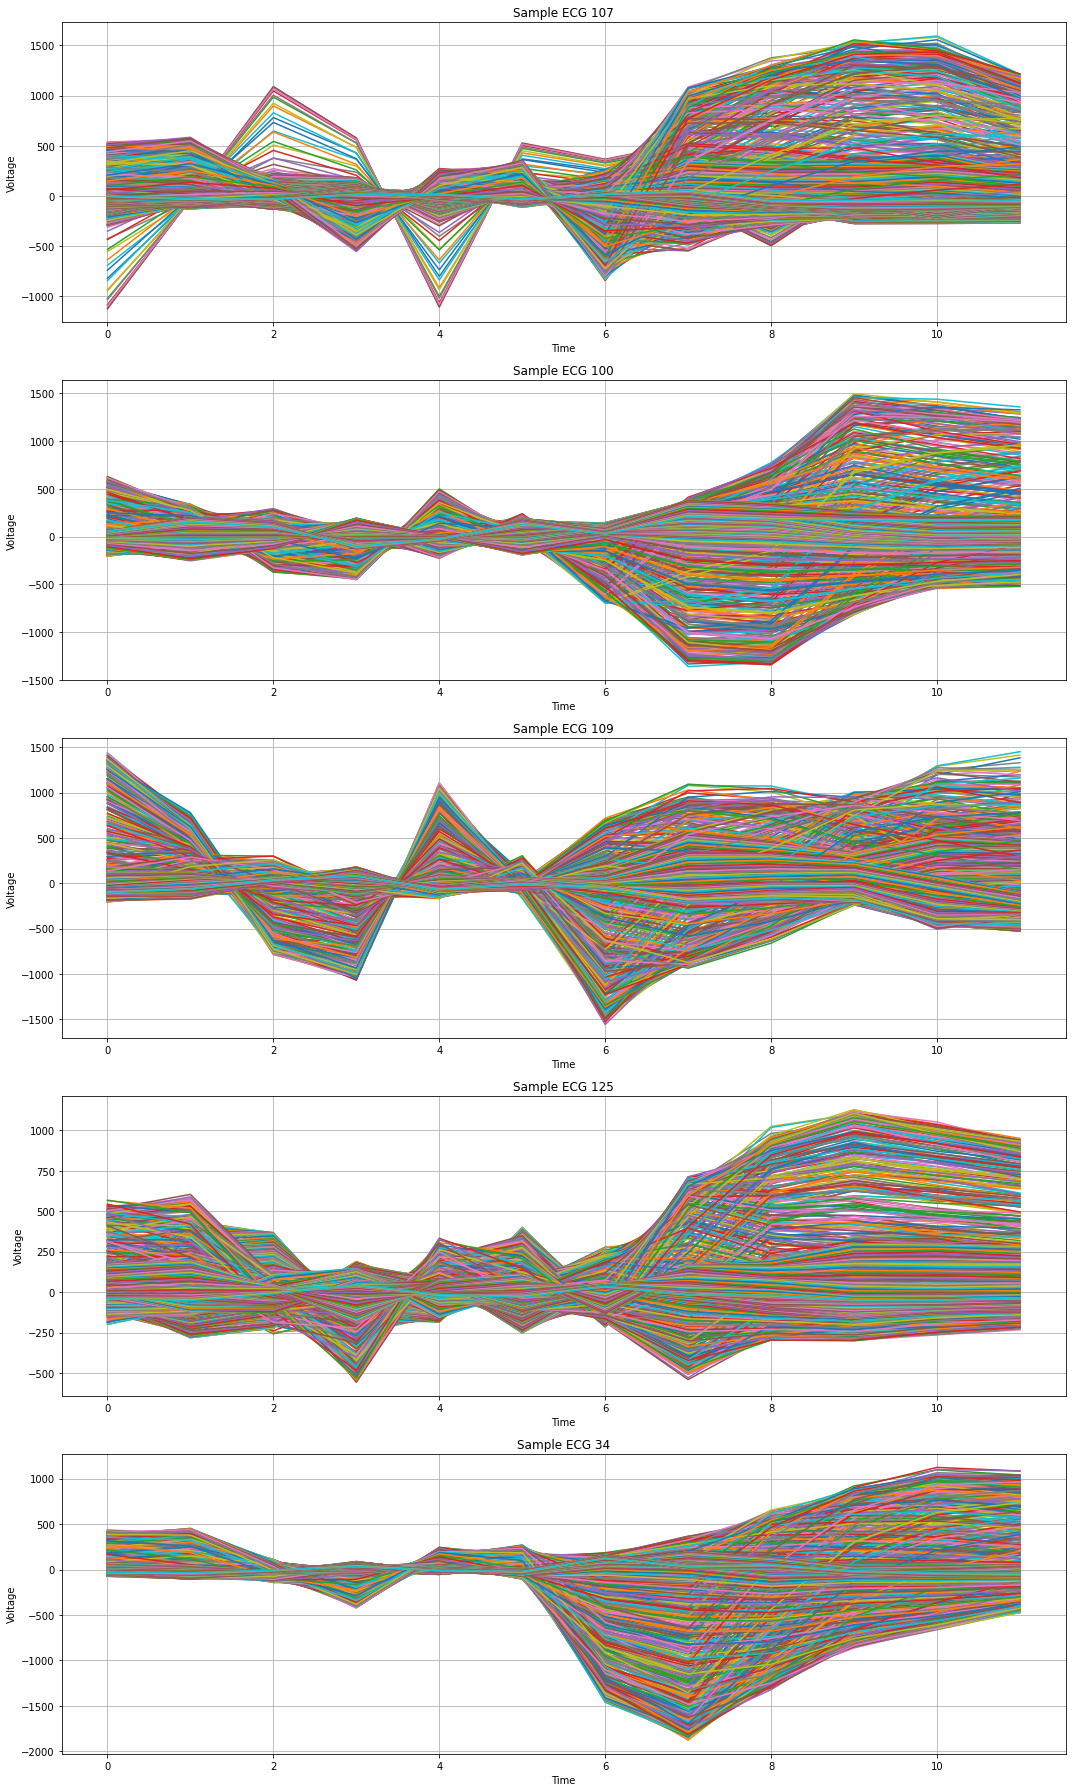

100%|████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 113686.03it/s]


In [2]:
#library imports
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from keras.utils import pad_sequences
import neurokit2 as nk
normal_sinus_dir = "C:/Users/NEHAL NAGPAL/Desktop/dataset/normal"
wpw_dir = "C:/Users/NEHAL NAGPAL/Desktop/dataset/wpw"
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data
def import_ecg_data(directory, ecg_len = 5000, trunc="post", pad="post"):
    print("Starting ECG import..")
    ecgs = []
    for ecgfilename in tqdm(sorted(os.listdir(directory))):
        filepath = directory + os.sep + ecgfilename
        if filepath.endswith(".mat"):
            data, header_data = load_challenge_data(filepath)
            data = pad_sequences(data, maxlen=ecg_len, truncating=trunc,padding=pad)
            ecgs.append(data)
    print("Finished!")
    return np.asarray(ecgs)
normal_sinus = import_ecg_data(normal_sinus_dir)
wpw = import_ecg_data(wpw_dir)
num_samples = 5
sample_indices = np.random.choice(len(wpw), num_samples, replace=False)
plt.figure(figsize=(15, 5*num_samples))
for i, idx in enumerate(sample_indices):
    plt.subplot(num_samples, 1, i+1)
    plt.plot(wpw[idx])
    plt.title(f"Sample ECG {idx}")
    plt.xlabel("Time")
    plt.ylabel("Voltage")
    plt.grid(True)
plt.tight_layout()
plt.show()
num_samples = 5
sample_indices = np.random.choice(len(normal_sinus), num_samples, replace=False)
plt.figure(figsize=(15, 5*num_samples))
for i, idx in enumerate(sample_indices):
    plt.subplot(num_samples, 1, i+1)
    plt.plot(normal_sinus[idx])
    plt.title(f"Sample ECG {idx}")
    plt.xlabel("Time")
    plt.ylabel("Voltage")
    plt.grid(True)
plt.tight_layout()
plt.show()

def resample_beats(beats):
    rsmp_beats=[]
    for i in beats:
        i = np.asarray(i)
        f = signal.resample(i, 250)
        rsmp_beats.append(f)
    rsmp_beats = np.asarray(rsmp_beats)
    return rsmp_beats
def median_beat(beat_dict):
    beats = []
    for i in beat_dict.values():
        beats.append(i['Signal'])
    beats = np.asarray(beats)
    rsmp_beats = resample_beats(beats)
    med_beat = np.median(rsmp_beats,axis=0)
    return med_beat
def remove_nans(ecg_arr):
    new_arr = []
    for i in tqdm(ecg_arr):
        twelve_lead = []
        for j in i:
            if j[0] != j[0]:
                j = np.ones(250)
            twelve_lead.append(j)
        new_arr.append(twelve_lead)
    new_arr = np.asarray(new_arr)
    return new_arr
new_norm = remove_nans(normal_sinus)
new_wpw = remove_nans(wpw)
def remove_some_ecgs(ecg_arr):
    delete_list = []
    for i in tqdm(range(len(ecg_arr))):
        if np.all(ecg_arr[i].T[0]==1):
            delete_list.append(i)
    ecg_arr = np.delete(ecg_arr,delete_list,axis=0)
    return ecg_arr
clean_wpw = remove_some_ecgs(new_wpw)
clean_norm = remove_some_ecgs(new_norm)
clean_wpw = np.moveaxis(clean_wpw, 1, -1)
clean_norm = np.moveaxis(clean_norm, 1, -1)
norm_train = clean_norm[:-30]
norm_val = clean_norm[-30:]
wpw_train = clean_wpw[:50]
wpw_val = clean_wpw[50:]
y_norm_train = np.zeros(norm_train.shape[0])
y_norm_val = np.zeros(norm_val.shape[0])
y_wpw_train = np.ones(wpw_train.shape[0])
y_wpw_val = np.ones(wpw_val.shape[0])
X_train = np.vstack([norm_train,wpw_train])
y_train = np.hstack([y_norm_train,y_wpw_train])
X_val = np.vstack([norm_val,wpw_val])
y_val = np.hstack([y_norm_val,y_wpw_val])

In [9]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
def LeNet():
    model = keras.Sequential()
    model.add(Conv1D(filters=6, kernel_size=5, activation='relu', input_shape=(5000, 12)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = LeNet()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[reduce_lr, early_stop])

Epoch 1/50
6/6 [==============================] - 1s 119ms/step - loss: 89.3502 - accuracy: 0.6111 - val_loss: 24.7948 - val_accuracy: 0.6857 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - 0s 81ms/step - loss: 31.3842 - accuracy: 0.7167 - val_loss: 361.0722 - val_accuracy: 0.2357 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - 0s 80ms/step - loss: 10.0060 - accuracy: 0.8833 - val_loss: 34.8072 - val_accuracy: 0.4857 - lr: 0.0010
Epoch 4/50
6/6 [==============================] - 0s 82ms/step - loss: 2.1896 - accuracy: 0.9222 - val_loss: 243.1086 - val_accuracy: 0.2357 - lr: 0.0010
Epoch 5/50
6/6 [==============================] - 0s 84ms/step - loss: 1.6269 - accuracy: 0.9444 - val_loss: 211.9171 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 6/50
6/6 [==============================] - 1s 88ms/step - loss: 3.7437e-10 - accuracy: 1.0000 - val_loss: 153.2843 - val_accuracy: 0.3214 - lr: 0.0010
Epoch 7/50
6/6 [==============================] - 0s 86ms/step - loss:

In [10]:
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation accuracy:", accuracy)

5/5 [==============================] - 0s 14ms/step - loss: 24.7948 - accuracy: 0.6857
Validation accuracy: 0.6857143044471741
